In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)
    
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Optimal Strategies & Trading parameters

In [2]:
strategies  = {'imbalance' : {'name'             : 'imbalance',
                              'params'           : {'feature_name'     : 'imbalance_1',
                                                      'estimation_period': '1min',
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}},
               
               'trend' : {'name'             : 'imbalance',
                            'params'           : {'feature_name'     : 'LT',
                                                  'estimation_period': '1min', 
                                                  'use_interpolator' : False,
                                                  'alpha'            : 10, 
                                                  'phi'              : 0.001, 
                                                  'kappa'            : 9e-10},
                            'contextual_params': {'feature_name'  : 'vol_50_50000'}},
               
               'twap'        : {'name'             : 'TWAP',
                                'params'           : {'feature_name'     : 'imbalance_3',
                                                      'estimation_period': '1min', 
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}}}


strategies  = {'imbalance' : {'name'             : 'imbalance',
                              'params'           : {'feature_name'     : 'imbalance_1',
                                                      'estimation_period': '1min',
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}}}

# GP bandits

In [7]:
from AOE.gp_bandit import gp_bandit, Wasserstein_GP_mean, Wasserstein_GP

In [4]:
# Likelihood models & non stationarity params
likelihood              = gpytorch.likelihoods.GaussianLikelihood()
size_buffer = 100
# Bandit objects
bandits = {'TS'  : gp_bandit(strategies, likelihood, size_buffer, bandit_algo='TS'), 
           'UCB' : gp_bandit(strategies, likelihood, size_buffer, bandit_algo='UCB', bandit_params=0.1) }

bandits = {'TS'  : gp_bandit(strategies, likelihood, size_buffer, bandit_algo='TS')}



# Trading simulation

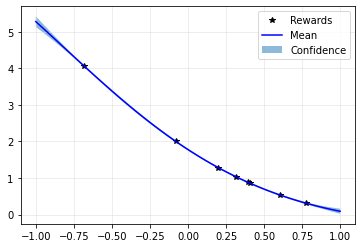

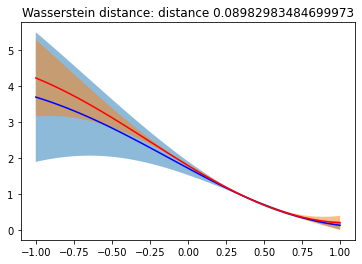

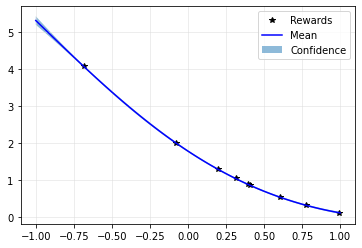

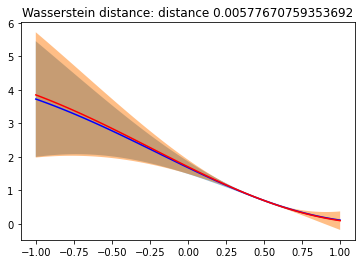

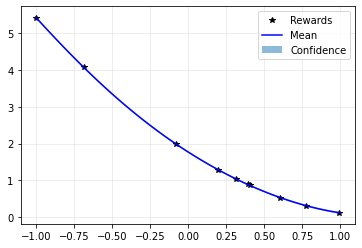

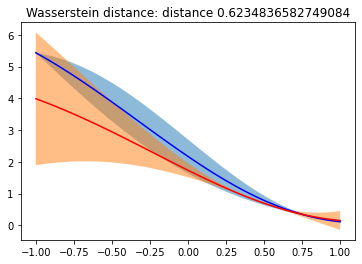

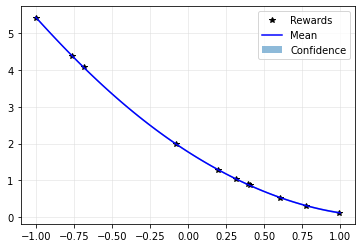

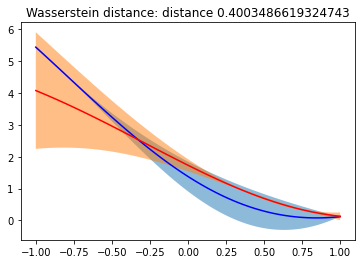

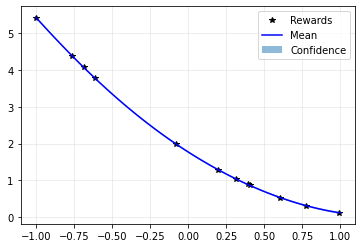

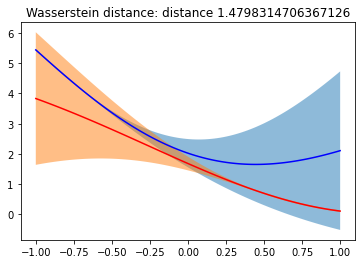

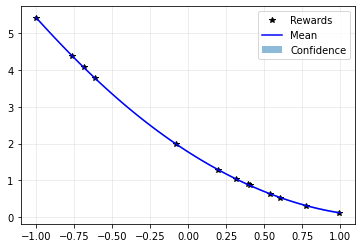

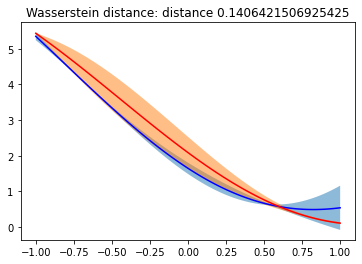

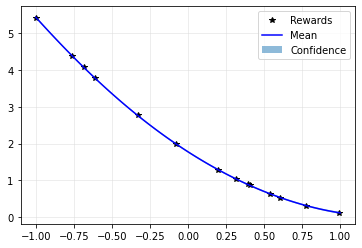

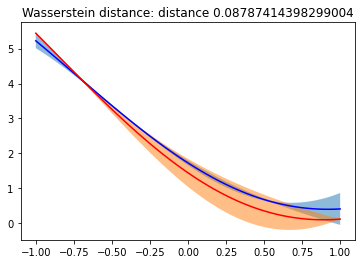

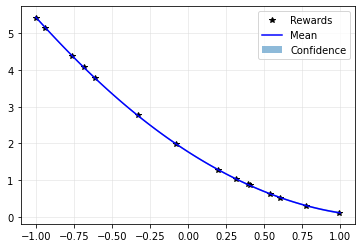

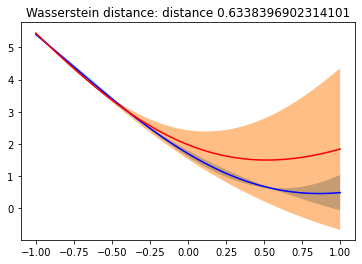

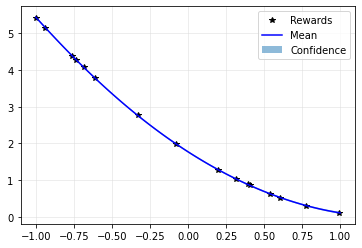

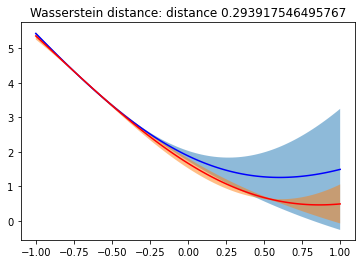

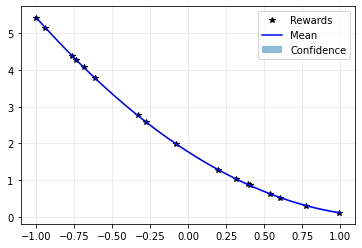

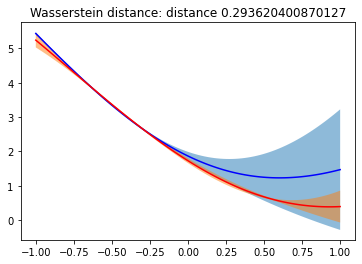

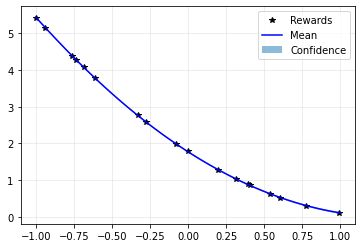

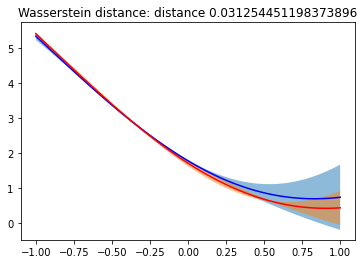

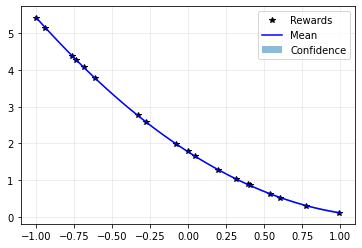

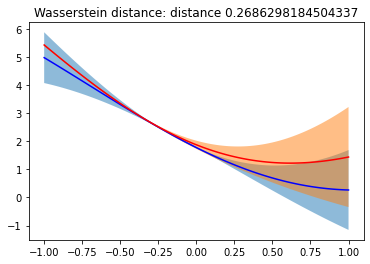

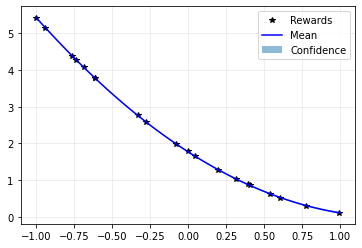

---------------Change of regime!!!! ------------------


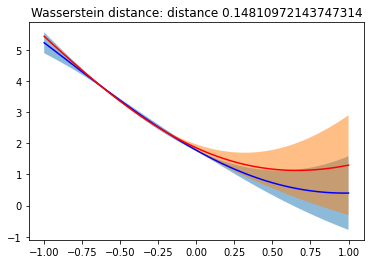

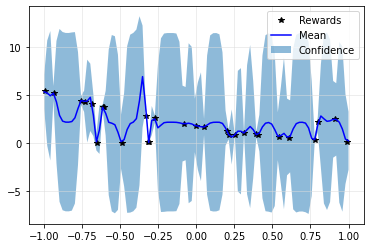

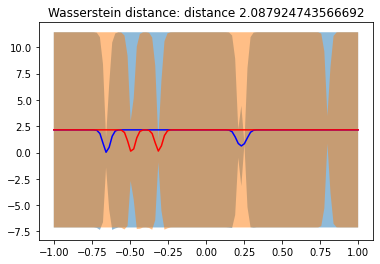

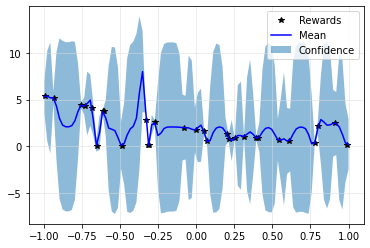

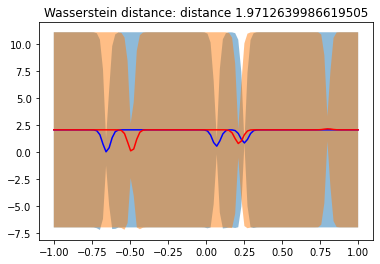

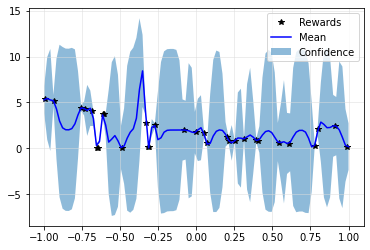

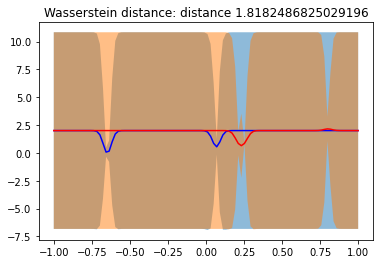

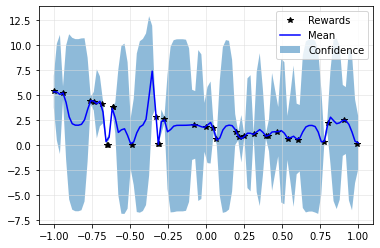

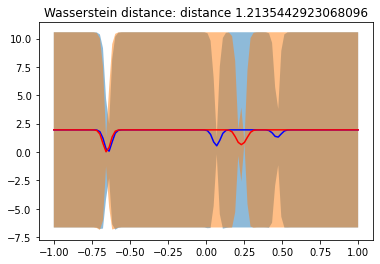

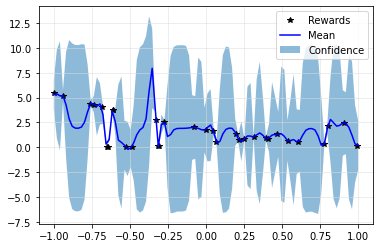

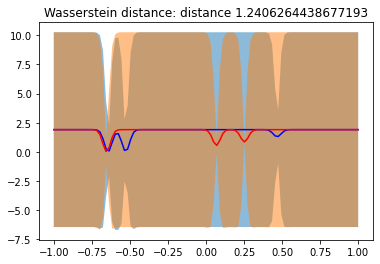

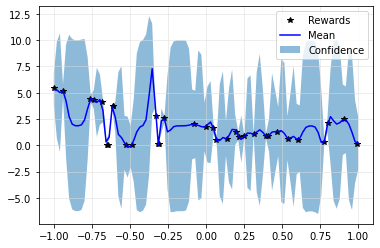

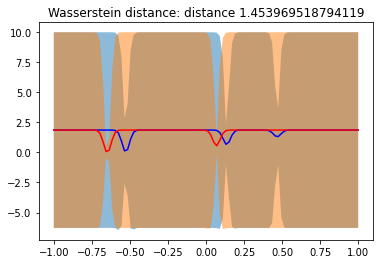

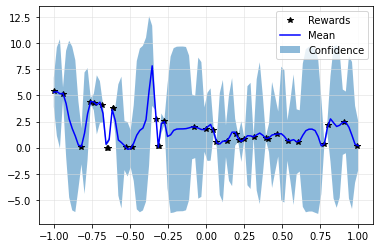

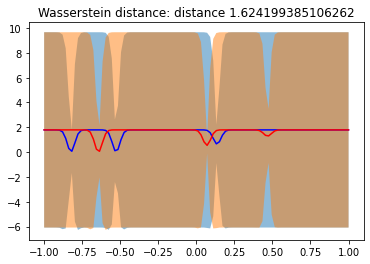

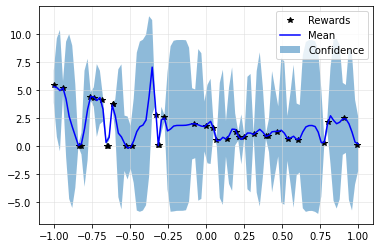

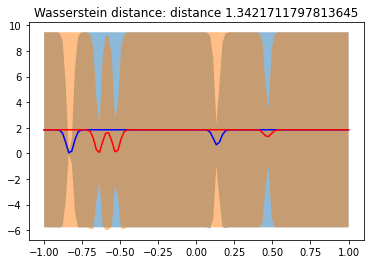

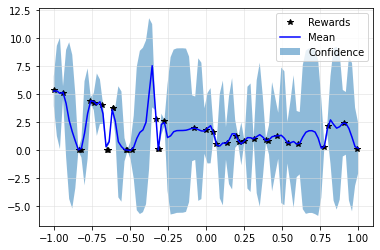

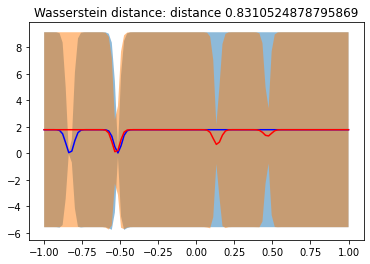

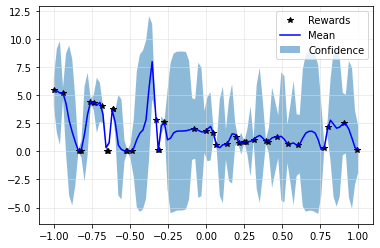

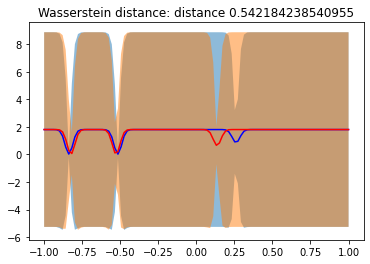

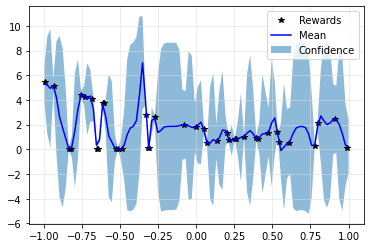

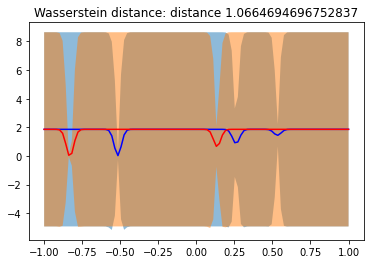

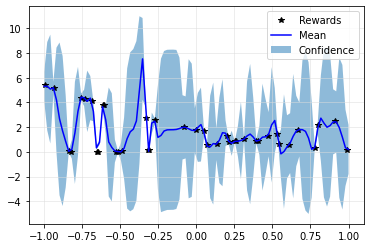

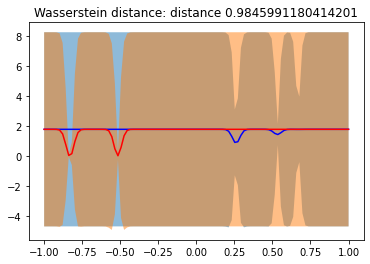

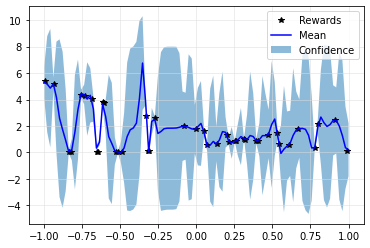

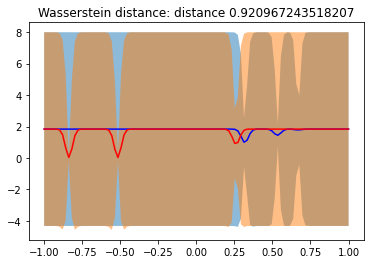

In [14]:
%matplotlib inline

## Plot both gp and value ucb at each time step with data point
## Try non stationarity
## Create synthetic random datapoints
bandit = gp_bandit(strategies, likelihood, size_buffer, bandit_algo='TS')
reward_imbalance = lambda x: (x-1.333)**2
reward_trend = lambda x: 1
reward_twap = lambda x: (x + 0.66666)**2
d = {'vol_50_50000': np.random.normal()}

for i in range(20):
    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    if best_strategy_bandit == "imbalance":
        reward = reward_imbalance(d['vol_50_50000'])
    elif best_strategy_bandit == "trend":
        reward = reward_trend(d['vol_50_50000'])
    else:
        reward = reward_twap(d['vol_50_50000']) 
    
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    if i > 6:
        bandit.plot_fit_strat("imbalance")
        
        posterior_mean_1, lower1, upper1, posterior_mean_2, lower2, upper2 = bandit.posterior_sliding_window_plot("imbalance")
        test_x = torch.linspace(-1, 1, 100).double()
        f, ax = plt.subplots(1, 1)

        ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b')
        ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r')
        
        posterior_mean_1, posterior_covar_1, posterior_mean_2, posterior_covar_2 = bandit.posterior_sliding_window("imbalance")
        
        distance = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
        ax.set_title(f"Wasserstein distance: distance {distance}")
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
        #bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)
        
print("---------------Change of regime!!!! ------------------")
for i in range(20):
    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    if best_strategy_bandit == "imbalance":
        reward = reward_twap(d['vol_50_50000'])
    elif best_strategy_bandit == "trend":
        reward = reward_trend(d['vol_50_50000'])
    else:
        reward = reward_twap(d['vol_50_50000']) 
    
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    if i > 6:
        bandit.plot_fit_strat("imbalance")
        
        posterior_mean_1, lower1, upper1, posterior_mean_2, lower2, upper2 = bandit.posterior_sliding_window_plot("imbalance")
        test_x = torch.linspace(-1, 1, 100).double()
        f, ax = plt.subplots(1, 1)

        ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b')
        ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r')
        
        posterior_mean_1, posterior_covar_1, posterior_mean_2, posterior_covar_2 = bandit.posterior_sliding_window("imbalance")
        
        distance = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
        ax.set_title(f"Wasserstein distance: distance {distance}")
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
        #bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)